In [52]:
import pandas as pd
import h5py
import io
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import torch
from torchvision import transforms
import matplotlib.pyplot as plt



## Create Custom Dataset 

In [53]:
#Dataset for image 
class ImageDataset(Dataset):
    def __init__(self, hdf5_file, csv_file, transform=None):
        # Open the HDF5 file with error handling
        try:
            self.hdf5_file = h5py.File(hdf5_file, 'r')  # Read-only mode
        except Exception as e:
            raise IOError(f"Could not open HDF5 file: {hdf5_file}. Error: {e}")

        # Read the CSV file containing image labels and IDs
        try:
            self.labels_df = pd.read_csv(csv_file)
        except Exception as e:
            raise IOError(f"Could not read CSV file: {csv_file}. Error: {e}")

        # Ensure that all image IDs from the CSV are present in the HDF5 file
        self.image_ids = self.labels_df['isic_id'].values
        for image_id in self.image_ids:
            if str(image_id) not in self.hdf5_file.keys():
                raise ValueError(f"Image id {image_id} not found in HDF5 file.")

        # Store any transformations to be applied to the images
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the image ID from the CSV file based on index
        image_id = str(self.labels_df.iloc[idx]['isic_id'])
        
        # Load the image data from the HDF5 file
        image_bytes = self.hdf5_file[image_id][()]
        
        # Convert the image bytes to a PIL Image
        image = Image.open(io.BytesIO(image_bytes))
        
        # Apply any specified transformations to the image
        if self.transform:
            image = self.transform(image)
        
        return image  # Return the image only


In [54]:
#Dataset for features and labels
class FeatureDataset(Dataset):
    def __init__(self, csv_file):
        # Read the CSV file containing image labels and additional features
        try:
            self.labels_df = pd.read_csv(csv_file)
        except Exception as e:
            raise IOError(f"Could not read CSV file: {csv_file}. Error: {e}")

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Retrieve the label
        label = self.labels_df.iloc[idx]['target']
        
        # Convert label to a tensor
        label_tensor = torch.tensor(label, dtype=torch.long)  # Adjust dtype as needed
        
        # Retrieve other features, excluding 'isic_id' and 'target'
        other_variables = self.labels_df.iloc[idx].drop(['isic_id', 'target']).values.astype(float)
        
        # Convert other variables to a tensor
        other_variable_tensor = torch.tensor(other_variables, dtype=torch.float32)  # Adjust dtype as needed
        
        return label_tensor, other_variable_tensor  # Return label and other variables


In [55]:
# Define any necessary transformations for the image dataset
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),#resize 
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),  # Rotate images randomly by 10 degrees
    transforms.ToTensor(),

])

normal_transform = transforms.Compose([
    transforms.Resize((128, 128)),#resize 
    transforms.ToTensor()

])



## Train DataLoader

In [56]:
# Create an instance of the image dataset
train_image_dataset = ImageDataset(hdf5_file='../data/raw/train_images.hdf5', 
                             csv_file='../data/processed/processed-train-metadata1.csv', 
                             transform=train_transform)

# Create a DataLoader for the image dataset
train_image_dataloader = DataLoader(train_image_dataset, batch_size=32, shuffle=True)

# Create an instance of the features dataset
train_feature_dataset = FeatureDataset(csv_file='../data/processed/processed-train-metadata1.csv')

# Create a DataLoader for the features dataset
train_feature_dataloader = DataLoader(train_feature_dataset, batch_size=32, shuffle=True)

Batch 1:
 - Number of images: 32
 - Image shape: torch.Size([3, 128, 128])
 - Data type: torch.float32


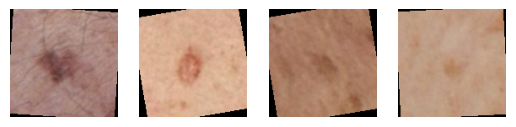

Batch 2:
 - Number of images: 32
 - Image shape: torch.Size([3, 128, 128])
 - Data type: torch.float32


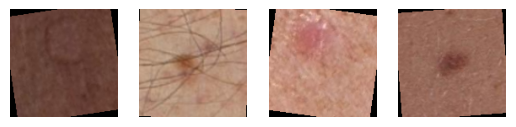

In [57]:
# 2. Check data shapes and types in a few batches
for i, (images) in enumerate(train_image_dataloader):
    print(f"Batch {i + 1}:")
    print(f" - Number of images: {images.shape[0]}")
    print(f" - Image shape: {images.shape[1:]}")  # Assuming images are in shape (B, C, H, W)
    print(f" - Data type: {images.dtype}")

    # 3. Visualize images
    for j in range(min(4, images.shape[0])):  # Display up to 4 images
        plt.subplot(1, 4, j + 1)
        img = images[j].permute(1, 2, 0).detach().numpy()  # Change shape to (H, W, C)
        plt.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
        plt.axis('off')
    plt.show()

    if i == 1:  # Display only the first two batches for testing
        break

In [58]:
# Create an instance of the validation image dataset
val_image_dataset = ImageDataset(hdf5_file='../data/raw/validation_image.hdf5', 
                                   csv_file='../data/processed/processed-validation-metadata1.csv',
                                    transform=normal_transform)
val_image_dataloader = DataLoader(val_image_dataset, batch_size=32,shuffle=False )
# Create an instance of the features dataset
val_feature_dataset = FeatureDataset(csv_file='../data/processed/processed-validation-metadata1.csv')

# Create a DataLoader for the features dataset
val_feature_dataloader = DataLoader(val_feature_dataset, batch_size=32, shuffle=False)


## Validation Data Loader|

Batch 1:
 - Number of images: 32
 - Image shape: torch.Size([3, 128, 128])
 - Data type: torch.float32


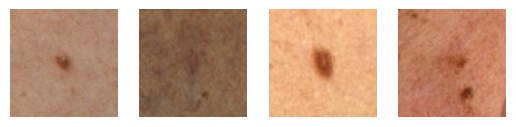

Batch 2:
 - Number of images: 32
 - Image shape: torch.Size([3, 128, 128])
 - Data type: torch.float32


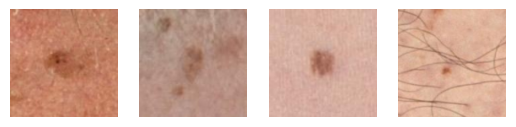

In [59]:
# 2. Check data shapes and types in a few batches
for i, (images) in enumerate(val_image_dataloader):
    print(f"Batch {i + 1}:")
    print(f" - Number of images: {images.shape[0]}")
    print(f" - Image shape: {images.shape[1:]}")  # Assuming images are in shape (B, C, H, W)
    print(f" - Data type: {images.dtype}")

    # 3. Visualize images
    for j in range(min(4, images.shape[0])):  # Display up to 4 images
        plt.subplot(1, 4, j + 1)
        img = images[j].permute(1, 2, 0).detach().numpy()  # Change shape to (H, W, C)
        plt.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
        plt.axis('off')
    plt.show()

    if i == 1:  # Display only the first two batches for testing
        break

## Test Dataloader

In [60]:
# Create an instance of the test image dataset
test_image_dataset = ImageDataset(hdf5_file='../data/raw/test_image.hdf5', 
                                   csv_file='../data/processed/processed-test-metadata1.csv',
                                     transform = normal_transform)
test_image_dataloader = DataLoader(test_image_dataset, batch_size=32,shuffle=False)
# Create an instance of the features dataset
test_feature_dataset = FeatureDataset(csv_file='../data/processed/processed-test-metadata1.csv')

# Create a DataLoader for the features dataset
test_feature_dataloader = DataLoader(test_feature_dataset, batch_size=32, shuffle=False)